In [523]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import learn

In [524]:
# Sets logging to INFO to see all information from TensorFlow.

tf.logging.set_verbosity(tf.logging.INFO)

In [525]:
BASE_DIR = 'dropout_intuition/'

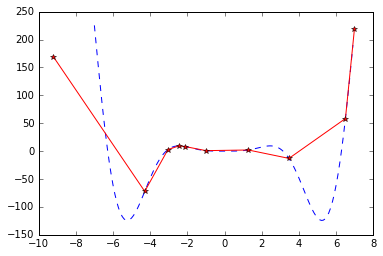

In [569]:
# Generate data.

rnd = np.random.RandomState(1)
f = lambda x: x ** 3 * np.sin(x)
x = np.array(np.arange(-7, 7, 0.1))
y = f(x)
train_x = np.array(sorted(rnd.normal(0, 4, 10)))
train_y = f(train_x)
plt.plot(x, y, '--')
_ = plt.plot(train_x, train_y, '-*', c='r')

In [535]:
regressor = learn.LinearRegressor(
    feature_columns=[layers.real_valued_column('')], model_dir=BASE_DIR + 'linear')
regressor.fit(x=train_x, y=train_y, steps=100)
pred_y = regressor.predict(x=x)

INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=1, default_value=None, dtype=tf.float32)
INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Restored model from dropout_intuition/linear/model.ckpt-100-?????-of-00001
INFO:tensorflow:Step 101: loss = 8851.39
INFO:tensorflow:Saving checkpoints for 200 into dropout_intuition/linear/model.ckpt.
INFO:tensorflow:Loss for final step: 8208.33.
INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=1, default_value=None, dtype=tf.float32)
INFO:tensorflow:Loading model from checkpoint: dropout_intuition/linear/model.ckpt-200-?????-of-00001.


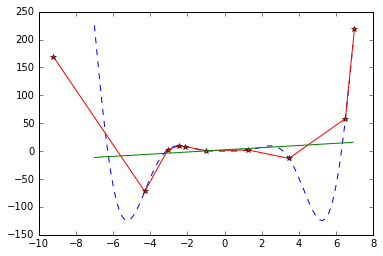

In [543]:
plt.plot(x, y, '--')
plt.plot(train_x, train_y, '-*', c='r')
_ = plt.plot(x, pred_y, '-', c='g')

In [537]:
dnn_regressor = learn.DNNRegressor(hidden_units=[2, 2],
    feature_columns=[layers.real_valued_column('')], model_dir=BASE_DIR + 'dnn', enable_centered_bias=False)
dnn_regressor.fit(x=train_x, y=train_y, steps=1000)
dnn_pred_y = dnn_regressor.predict(x=x)

INFO:tensorflow:Transforming feature_column _RealValuedColumn(column_name='', dimension=1, default_value=None, dtype=tf.float32)
INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 8333.43
INFO:tensorflow:Step 101: loss = 4586.61
INFO:tensorflow:Step 201: loss = 3928.42
INFO:tensorflow:Saving checkpoints for 300 into dropout_intuition/dnn/model.ckpt.
INFO:tensorflow:Step 301: loss = 3737.19
INFO:tensorflow:Step 401: loss = 3596.53
INFO:tensorflow:Step 501: loss = 3472.79
INFO:tensorflow:Saving checkpoints for 600 into dropout_intuition/dnn/model.ckpt.
INFO:tensorflow:Step 601: loss = 3359.1
INFO:tensorflow:Step 701: loss = 3253.89
INFO:tensorflow:Step 801: loss = 3157.58
INFO:tensorflow:Saving checkpoints for 900 into dropout_intuition/dnn/model.ckpt.
INFO:tensorflow:Step 901: loss = 3059.58
INFO:tensorflow:Saving checkpoints for 1000 into dropout_intuition/dnn/model.ckpt.
INFO:tensorflow:Loss for final step: 2959.44.
INFO:tensorflow:Transforming feature_column _RealV

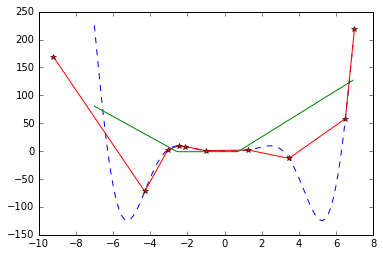

In [542]:
plt.plot(x, y, '--')
plt.plot(train_x, train_y, '-*', c='r')
_ = plt.plot(x, dnn_pred_y, '-', c='g')

In [539]:
def custom_dnn_model(feature, target):
    tf.identity(feature, name='feature')
    feature = layers.fully_connected(feature, 2)
    feature = layers.fully_connected(feature, 2)
    predictions = layers.fully_connected(feature, 1, activation_fn=None)
    loss = tf.contrib.losses.sum_of_squares(tf.squeeze(predictions, [1]), target)
    train_op = layers.optimize_loss(loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, optimizer='Adagrad')
    return predictions, loss, train_op

custom_dnn_regressor = learn.Estimator(model_fn=custom_dnn_model, model_dir=BASE_DIR + 'custom_dnn')
custom_dnn_regressor.fit(x=train_x, y=train_y, steps=1000)
custom_pred_y = custom_dnn_regressor.predict(x=x)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 8464.0
INFO:tensorflow:Step 101: loss = 5752.88
INFO:tensorflow:Step 201: loss = 4437.13
INFO:tensorflow:Saving checkpoints for 300 into dropout_intuition/custom_dnn/model.ckpt.
INFO:tensorflow:Step 301: loss = 4065.42
INFO:tensorflow:Step 401: loss = 3920.23
INFO:tensorflow:Step 501: loss = 3818.68
INFO:tensorflow:Saving checkpoints for 600 into dropout_intuition/custom_dnn/model.ckpt.
INFO:tensorflow:Step 601: loss = 3731.72
INFO:tensorflow:Step 701: loss = 3653.35
INFO:tensorflow:Step 801: loss = 3580.14
INFO:tensorflow:Saving checkpoints for 900 into dropout_intuition/custom_dnn/model.ckpt.
INFO:tensorflow:Step 901: loss = 3509.93
INFO:tensorflow:Saving checkpoints for 1000 into dropout_intuition/custom_dnn/model.ckpt.
INFO:tensorflow:Loss for final step: 3442.82.
INFO:tensorflow:Loading model from checkpoint: dropout_intuition/custom_dnn/model.ckpt-1000-?????-of-00001.


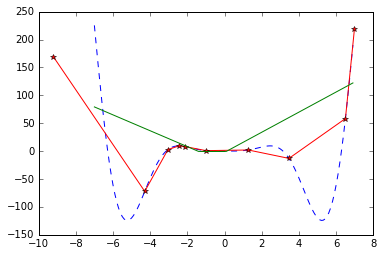

In [540]:
plt.plot(x, y, '--')
plt.plot(train_x, train_y, '-*', c='r')
_ = plt.plot(x, custom_pred_y, '-', c='g')

In [544]:
def uncertanty_dnn_model(x, target, mode):
    def logits(feature, is_training_or_sample):
        feature = layers.fully_connected(feature, 5)
        feature = layers.dropout(feature, 0.9, is_training=is_training_or_sample)
        feature = layers.fully_connected(feature, 5)
        feature = layers.dropout(feature, 0.9, is_training=is_training_or_sample)
        return layers.fully_connected(feature, 1, activation_fn=None)
    with tf.variable_scope('dnn'):
        predictions = logits(x, is_training_or_sample=mode == learn.ModeKeys.TRAIN)
    with tf.variable_scope('dnn', reuse=True):
        sampled_predictions = logits(x, is_training_or_sample=True)
    loss = tf.contrib.losses.sum_of_squares(tf.squeeze(predictions, [1]), target)
    train_op = layers.optimize_loss(loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, optimizer='Adagrad')
    return {'target': predictions, 'sampled_predictions': sampled_predictions}, loss, train_op

dropout_dnn_regressor = learn.Estimator(model_fn=uncertanty_dnn_model, model_dir=BASE_DIR + 'dnn_dropout')
dropout_dnn_regressor.fit(x=train_x, y=train_y, steps=4000)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 8508.77
INFO:tensorflow:Step 101: loss = 5886.68
INFO:tensorflow:Step 201: loss = 3266.83
INFO:tensorflow:Saving checkpoints for 300 into dropout_intuition/dnn_dropout/model.ckpt.
INFO:tensorflow:Step 301: loss = 3250.17
INFO:tensorflow:Step 401: loss = 3851.59
INFO:tensorflow:Step 501: loss = 5688.8
INFO:tensorflow:Saving checkpoints for 600 into dropout_intuition/dnn_dropout/model.ckpt.
INFO:tensorflow:Step 601: loss = 3628.05
INFO:tensorflow:Step 701: loss = 3147.12
INFO:tensorflow:Step 801: loss = 5216.15
INFO:tensorflow:Saving checkpoints for 900 into dropout_intuition/dnn_dropout/model.ckpt.
INFO:tensorflow:Step 901: loss = 5196.17
INFO:tensorflow:Step 1001: loss = 7120.92
INFO:tensorflow:Step 1101: loss = 2948.97
INFO:tensorflow:Saving checkpoints for 1200 into dropout_intuition/dnn_dropout/model.ckpt.
INFO:tensorflow:Step 1201: loss = 3250.86
INFO:tensorflow:Step 1301: loss = 5373.95
INFO:tensorflow:Step 1401

Estimator(params=None)

INFO:tensorflow:Loading model from checkpoint: dropout_intuition/dnn_dropout/model.ckpt-4000-?????-of-00001.


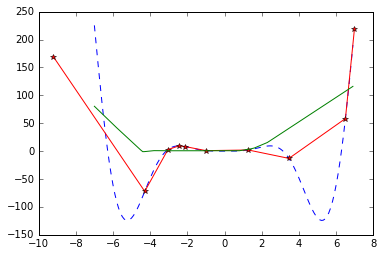

In [545]:
dropout_pred_y = dropout_dnn_regressor.predict(x=x, outputs=['target'])['target']
plt.plot(x, y, '--')
plt.plot(train_x, train_y, '-*', c='r')
_ = plt.plot(x, dropout_pred_y, '-', c='g')

In [546]:
# Sample predictions N times.
n_samples = 10

samples = []
x_samples = np.concatenate([x for _ in range(n_samples)])
y_samples = dropout_dnn_regressor.predict(x=x_samples, outputs=['sampled_predictions'])['sampled_predictions']
samples = [y_samples[i * len(x):(i + 1) * len(x)] for i in range(n_samples)]

INFO:tensorflow:Loading model from checkpoint: dropout_intuition/dnn_dropout/model.ckpt-4000-?????-of-00001.


In [547]:
def t_confidence(a, confidence=0.95):
  m, se = np.mean(a), scipy.stats.sem(a)
  h = se * scipy.stats.t._ppf((1+confidence)/2., len(a) - 1)
  return h

def min_max(a):
    return np.max(a) - np.min(a)

confidence_intervals = []
for i, el in enumerate(x):
    a = [samples[j][i] for j in range(n_samples)]
    confidence_intervals.append(t_confidence(a))

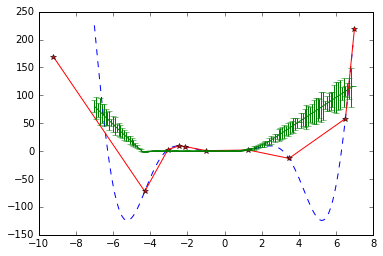

In [548]:
plt.plot(x, y, '--')
plt.plot(train_x, train_y, '-*', c='r')
_ = plt.errorbar(x, dropout_pred_y, yerr=confidence_intervals)

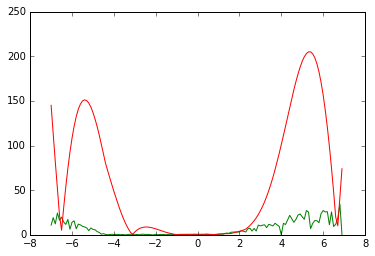

In [581]:
error_rate = np.abs(y - dropout_pred_y.reshape([-1]))

_ = plt.plot(x, confidence_intervals, c='g')
_ = plt.plot(x, error_rate, c='r')